This notebook is an example of typical classification codes for the OSU meeting QSO data-challenge. To use the KNN and BDT classifiers you will need the `sklearn`. For the last example (MLP) you will need the `keras` package.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from astropy.table import join
import astropy.io.fits as fits
import speclite #To downsample
import os

The data from DESI will be delivered in `brick` files. This function reads them.

In [3]:
def readBricks(path_in,brick_name):
    hdus = []
    for channel in 'brz':
        filename = 'brick-{}-{}.fits'.format(channel,brick_name)
        hdulist = fits.open(os.path.join(path_in,filename))
        hdus.append(hdulist)
    return hdus

In [6]:
hdus = readBricks(os.environ['FAKE_QSO_PATH'],'all-osu')
print hdus[0][0].shape, hdus[1][0].shape, hdus[2][0].shape

(3000, 4760) (3000, 4232) (3000, 4798)


In this example we decided to downsample to have a more tractable input signal

In [7]:
def downsample(camera,nspec,ndownsample, si=0):
    data = np.ones((nspec,len(hdus[camera][2].data[si:])), dtype=[('flux', float), ('ivar',float)])
    data['flux']=hdus[camera][0].data[:,si:]
    data['ivar']=hdus[camera][1].data[:,si:]
    return speclite.downsample(data,ndownsample,axis=1,weight='ivar')

In [8]:
flux_b = downsample(0,3000,20)
flux_r = downsample(1,3000,23)
flux_z = downsample(2,3000,35,si=3)
print flux_b.shape, flux_r.shape, flux_z.shape

(3000, 238) (3000, 184) (3000, 137)


In [9]:
qso_flux = np.hstack([flux_b,flux_r,flux_z])
print qso_flux.shape

(3000, 559)


In [10]:
table_train = Table.read(os.path.join(os.environ['FAKE_QSO_PATH'],'training_table_all.fits.gz'))

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#We use LabelEncoder that translates a label into an integer
encoder = LabelEncoder()
encoder.fit(table_train['TRUE_OBJTYPE'])
encoded_Y = encoder.transform(table_train['TRUE_OBJTYPE'])
#Now we have our data prepared

In [12]:
#We use 750 samples to train our algorithms and the rest for testing
ntrain=750
qso_class_train = encoded_Y[:ntrain]
qso_class_test = encoded_Y[ntrain:len(encoded_Y)]
qso_flux_train = qso_flux[:ntrain]
qso_flux_test = qso_flux[ntrain:len(encoded_Y)]

# KNN classifier

In [13]:
def quassifier_knn(kn):
    from sklearn.neighbors import KNeighborsClassifier
    efficiency = np.zeros(len(kn))
    purity = np.zeros(len(kn))
    i_best = 0
    qso_fit_best = None

    for i, knn in enumerate(kn):
        knc = KNeighborsClassifier(n_neighbors=knn)
        knc.fit(qso_flux_train, qso_class_train)

        qso_fit_train = knc.predict(qso_flux_train)
        qso_fit = knc.predict(qso_flux_test)
        good = np.count_nonzero(qso_fit==qso_class_test)/(1.0*len(qso_class_test))
        efficiency[i]=good
        if(good>qso_fit_best):
            qso_fit_best = good
            i_best = i
    plt.scatter(kn,efficiency)
    plt.xlabel('Number of neighbors')
    plt.ylabel('Efficiency')
    knc = KNeighborsClassifier(n_neighbors=kn[i_best])
    knc.fit(qso_flux_train,qso_class_train)
    results = knc.predict(qso_flux)
    return results

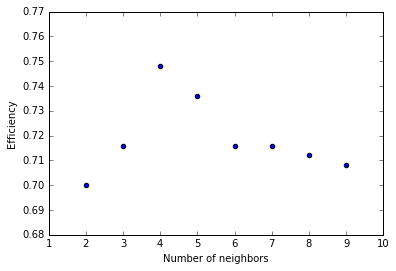

In [14]:
results = quassifier_knn(np.arange(2,10))

# BDT classifier (adaboost)

https://en.wikipedia.org/wiki/AdaBoost

In [15]:
def quassify_adaboost(number_estimators):
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier
    efficiency = np.zeros(len(number_estimators))
    purity = np.zeros(len(number_estimators))
    i_best =0
    qso_fit_best = None
    for i, ne in enumerate(number_estimators):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",n_estimators=ne)
        bdt.fit(qso_flux_train,qso_class_train)
        qso_fit = bdt.predict(qso_flux_test)
        good = np.count_nonzero(qso_fit==qso_class_test)/(1.0*len(qso_class_test))
        efficiency[i]=good
        if(good>qso_fit_best):
            qso_fit_best = good
            i_best = i
    plt.scatter(number_estimators,efficiency)
    plt.xlabel('Number of estimators')
    plt.ylabel('Efficiency')
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",n_estimators=number_estimators[i_best])
    bdt.fit(qso_flux_train,qso_class_train)
    results = bdt.predict(qso_flux)
    return results

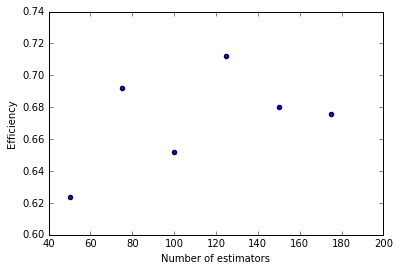

In [16]:
predicted_adaboost = quassify_adaboost(np.arange(50,200,25))

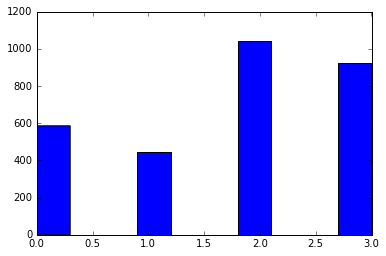

In [17]:
plt.hist(predicted_adaboost);

# Dense ANN

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(encoded_Y)

Using Theano backend.


In [19]:
seed = 7
numpy.random.seed(seed)

In [20]:
def create_baseline():
    model = Sequential()
    model.add(Dense(128, input_dim=qso_flux.shape[1], init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(16, init='normal', activation='relu'))
    model.add(Dense(8, init='normal', activation='relu'))
    model.add(Dense(4, init='normal', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, qso_flux[0:len(encoded_Y)], dummy_y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))